## Installation



In [ ]:
pip install wandb numpy pandas matplotlib torch torchvision

## Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/DL_Assignment2/Dataset/nature_12K.zip -d /content/drive/MyDrive/DL_Assignment2/Dataset

## Libraries

In [2]:
import torch
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import wandb
import tqdm
import gc
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

cuda


## Dataset loader

In [3]:
def validationDataSplit(train_dataset):
  classLabels = [label for _,label in train_dataset.samples]
  num_classes = len(np.unique(classLabels))

  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  train_indices, val_indices = next(sss.split(train_dataset.samples, classLabels))

  train_subset = Subset(train_dataset, train_indices)
  val_subset = Subset(train_dataset, val_indices)
  return train_subset, val_subset, num_classes


def load_data(base_dir, isDataAug, batch_size):
  train_dir = os.path.join(base_dir, 'train')
  test_dir = os.path.join(base_dir, 'val')

  train_transform, test_transform = None, None

  if isDataAug == False:
    train_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  else:
    train_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
  train_dataset, val_dataset, num_classes = validationDataSplit(train_dataset)

  # print(f"inp: {train_dataset[0][0].shape} {train_dataset[0][1]}")

  train_loader = DataLoader(train_dataset,shuffle=True,num_workers=2,batch_size=batch_size,pin_memory=True)
  test_loader = DataLoader(test_dataset,shuffle=True,num_workers=2,batch_size=64,pin_memory=True)
  val_loader = DataLoader(val_dataset,shuffle=True,num_workers=2,batch_size=64,pin_memory=True)

  return train_loader, test_loader, val_loader, num_classes

# load_data("/content/drive/MyDrive/DL_Assignment2/Dataset/inaturalist_12K/", True)

## Training CNN

In [5]:
class ConvolutionalNeuralNetwork(nn.Module):
  activationFunctionsMap = {"ReLU": nn.ReLU, "GELU": nn.GELU, "SiLU": nn.SiLU}
  # optimizersMap = {"sgd": optim.SGD, "rmsprop": optim.RMSprop, "adam": optim.Adam}

  def __init__(self, num_classes,
               num_filters, filter_sizes,
               activationFun, optimizer,
               n_neurons_denseLayer,
               isBatchNormalization, dropout,
               learning_rate=0.001,
               momentum=0.5, beta = 0.9,
               beta1=0.9, beta2=0.99,
               epsilon=1e-8, weight_decay=0.0001):
    super(ConvolutionalNeuralNetwork, self).__init__()
    self.num_classes = num_classes
    self.num_filters = num_filters
    self.filter_sizes = filter_sizes
    self.activationFun = ConvolutionalNeuralNetwork.activationFunctionsMap[activationFun]
    # self.optimizer = ConvolutionalNeuralNetwork.optimizersMap[optimizer]

    self.n_neurons_denseLayer = n_neurons_denseLayer
    self.isBatchNormalization = isBatchNormalization
    self.dropout = dropout

    self.lr = learning_rate
    self.momentum = momentum
    self.betas = (beta1, beta2)
    self.eps = epsilon
    self.alpha = beta
    self.weight_decay = weight_decay

    self.defineModel()

    if(optimizer == "sgd"):
      self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    elif(optimizer == "rmsprop"):
      self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr, alpha=self.alpha, eps=self.eps, weight_decay=self.weight_decay)
    elif(optimizer == "adam"):
      self.optimizer = optim.Adam(self.parameters(), lr=self.lr, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay)



  def defineModel(self):
    self.model = nn.Sequential()

    inChannels = 3;     # RGB channels for inaturalist
    for i in range(len(self.num_filters)):
      self.model.append(nn.Conv2d(inChannels, self.num_filters[i], self.filter_sizes[i], padding=self.filter_sizes[i]//2))
      if self.isBatchNormalization:
        self.model.append(nn.BatchNorm2d(self.num_filters[i]))
      self.model.append(self.activationFun())
      self.model.append(nn.MaxPool2d(kernel_size=2))
      inChannels = self.num_filters[i]

    # computing flattened size
    input_shape = (3, 224, 224)
    with torch.no_grad():
      dummy_input = torch.zeros(1, *input_shape)
      dummy_output = self.model(dummy_input)
      flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1)

    self.model.append(nn.Flatten())
    self.model.append(nn.Linear(flattened_size, self.n_neurons_denseLayer))
    self.model.append(self.activationFun())

    if(self.dropout > 0):
      self.model.append(nn.Dropout(self.dropout))

    self.model.append(nn.Linear(self.n_neurons_denseLayer, self.num_classes))

  def forward(self, inputs):
    return self.model(inputs)

  def backward(self, outputs, labels):
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()

  def updateWeights(self):
    self.optimizer.step()

In [13]:
sweep_configuration = {
    "method": "random",
    "name" : "train_sweep_final2_v1",
    "parameters": {
        "num_filters": {'values': [[32, 32, 32, 32, 32], [32, 64, 64, 128, 256], [256, 128, 64, 64, 32]]},
        "filter_sizes": {'values': [[3, 3, 3, 3, 3], [5, 5, 5, 5, 5],[3,3,5,5,1]]},
        "activation": {"values": ["ReLU", "SiLU", "GELU"]},
        "optimizer": {"values": ["adam", "rmsprop", "sgd"]},
        "learning_rate": {"values": [1e-3]},
        "weight_decay": {"values": [0.0001]},
        "momentum": {"values": [0.9]},
        "beta": {"values": [0.9]},
        "beta1": {"values":[0.9]},
        "beta2": {"values": [0.999]},
        "epsilon": {"values": [1e-8]},
        # "base_dir": {"values":["/content/drive/MyDrive/DL_Assignment2/Dataset/inaturalist_12K/"]},
        "base_dir": {"values": ["/kaggle/input/inaturalist/inaturalist_12K"]},
        "isDataAug": {"values": ["False", "True"]},
        "isBatchNormalization": {"values": ["True", "False"]},
        "dropout": {"values": [0.2, 0.3]},
        "n_neurons_denseLayer": {"values": [128, 256]},
        "batch_size": {"values": [32,64]},
        "epochs": {"values": [5,10]}
    }
}


def findOutputs(cnn, inputDataLoader, isTestData=False):
  cnn.eval()  # setting the model to evaluation model
  outputs = []
  total_loss = 0.0
  n_correct = 0
  n_correct_top5 = 0
  n_correct_top2 = 0
  n_samples = 0

  with torch.no_grad():
    for batch_idx, (x_batch, y_batch) in enumerate(inputDataLoader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      batch_outputs = cnn(x_batch)

      loss = nn.CrossEntropyLoss()(batch_outputs, y_batch)
      total_loss += loss.item() * x_batch.size(0)

      y_pred_batch = torch.argmax(batch_outputs, dim=1)
      n_correct += (y_pred_batch == y_batch).sum().item()
      n_samples += x_batch.size(0)

      if isTestData == True:
          y_pred_batch_top5 = torch.topk(batch_outputs, 5, dim=1).indices
          n_correct_top5 += y_pred_batch_top5.eq(y_batch.view(-1, 1)).sum().item()

          y_pred_batch_top2 = torch.topk(batch_outputs, 2, dim=1).indices
          n_correct_top2 += y_pred_batch_top2.eq(y_batch.view(-1, 1)).sum().item()
      outputs.append(batch_outputs)

  outputs = torch.cat(outputs)
  accuracy = (n_correct * 100.0) / n_samples
  avg_loss = total_loss / n_samples

  top5_accuracy = None
  top2_accuracy = None
  if isTestData == True:
      top5_accuracy = (n_correct_top5 * 100.0) / n_samples
      top2_accuracy = (n_correct_top2 * 100.0) / n_samples
  return outputs, accuracy, avg_loss, top5_accuracy, top2_accuracy

def trainNeuralNetwork_sweep():
  wandb.init(mode="online")
  args = wandb.config
  train_loader, test_loader, val_loader, num_classes = load_data(args["base_dir"], args["isDataAug"], args["batch_size"])
  activationFun = args["activation"]
  optimizer = args["optimizer"]
  learning_rate = args["learning_rate"]
  momentum = args["momentum"]
  beta = args["beta"]
  beta1 = args["beta1"]
  beta2 = args["beta2"]
  epsilon = args["epsilon"]
  weight_decay = args["weight_decay"]
  dropout = args["dropout"]
  num_filters = args["num_filters"]
  filter_sizes = args["filter_sizes"]
  n_neurons_denseLayer = args["n_neurons_denseLayer"]
  isBatchNormalization = args["isBatchNormalization"]
  isDataAug = args["isDataAug"]

  wandb.run.name = f"{activationFun}_{optimizer}_{dropout}_{n_neurons_denseLayer}_DataAug-{isDataAug}_BatchNorm-{isBatchNormalization}"
  best_val_accuracy = 0.0
  best_accuracy_epoch = -1

  cnn = ConvolutionalNeuralNetwork(num_classes,
                                   num_filters, filter_sizes,
                                   activationFun, optimizer,
                                   n_neurons_denseLayer,
                                   isBatchNormalization, dropout,
                                   learning_rate,
                                   momentum, beta,
                                   beta1, beta2,
                                   epsilon, weight_decay)
  cnn.to(device)

  epochs = args["epochs"]
  for epochNum in range(epochs):
    print(f"Epoch {epochNum}:")
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
      if(batch_idx % 40 == 0):
        print(f"Batch idx {batch_idx} running")
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      cnn.optimizer.zero_grad()
      outputs = cnn(x_batch)
      cnn.backward(outputs, y_batch)
      cnn.updateWeights()
      del x_batch, y_batch, outputs

    # Validation accuracy
    val_outputs, val_accuracy, val_loss, _, _ = findOutputs(cnn, val_loader)
    # wandb.run.summary["metric_name"] = val_accuracy
    print(f"validation: loss={val_loss}, accuracy={val_accuracy}")

    # Train accuracy
    train_outputs, train_accuracy, train_loss, _, _ = findOutputs(cnn, train_loader)
    print(f"training: loss={train_loss}, accuracy={train_accuracy}")

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_accuracy_epoch = epochNum

    wandb.log({
        "epoch": epochNum + 1,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy
        },commit=True)
    del val_outputs, train_outputs
    gc.collect()
    torch.cuda.empty_cache()      
      
  wandb.log({
      "best_acc_epoch": best_accuracy_epoch,
      "best_val_accuracy": best_val_accuracy
  })

  test_outputs, test_accuracy, test_loss, test_top5_accuracy, test_top2_accuracy = findOutputs(cnn, test_loader, True)
  print(f"testing: loss={test_loss}, top1_accuracy={test_accuracy}, top5_accuracy = {test_top5_accuracy}, top2_accuracy = {test_top2_accuracy}")

  wandb.log({
      "test_loss": test_loss,
      "test_top1_accuracy": test_accuracy,
      "test_top5_accuracy": test_top5_accuracy,
      "test_top2_accuracy": test_top2_accuracy
  })
  del cnn,train_loader, test_loader, val_loader
  gc.collect()
  torch.cuda.empty_cache()

  wandb.finish()

In [14]:
# best_acc_sweep_configuration = {
#     "method": "random",
#     "name" : "test_sweep1",
#     "parameters": {
#         "num_filters": {'values': [[256, 128, 64, 64, 32]]},
#         "filter_sizes": {'values': [[3, 3, 3, 3, 3]]},
#         "activation": {"values": ["SiLU"]},
#         "optimizer": {"values": ["sgd"]},
#         "learning_rate": {"values": [1e-3]},
#         "weight_decay": {"values": [0.0001]},
#         "momentum": {"values": [0.9]},
#         "beta": {"values": [0.9]},
#         "beta1": {"values":[0.9]},
#         "beta2": {"values": [0.999]},
#         "epsilon": {"values": [1e-8]},
#         # "base_dir": {"values":["/content/drive/MyDrive/DL_Assignment2/Dataset/inaturalist_12K/"]},
#         "base_dir": {"values": ["/kaggle/input/inaturalist/inaturalist_12K"]},
#         "isDataAug": {"values": ["False"]},
#         "isBatchNormalization": {"values": ["False"]},
#         "dropout": {"values": [0.3]},
#         "n_neurons_denseLayer": {"values": [128]},
#         "batch_size": {"values": [32]},
#         "epochs": {"values": [10]}
#     }
# }

In [15]:
wandb.login(key="73b92c51e182b0f526498c09acb70e0d4b8d6c14")
wandb_id = wandb.sweep(best_acc_sweep_configuration, project="DA6401_Assignment2")
wandb.agent(wandb_id, function=trainNeuralNetwork_sweep)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: vzeioiq7
Sweep URL: https://wandb.ai/nikhithaa-iit-madras/DA6401_Assignment2/sweeps/vzeioiq7


wandb: Agent Starting Run: fljlh8mm with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=2.0376094341278077, accuracy=27.75
training: loss=2.0114603939168467, accuracy=28.91611451431429
Epoch 1:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.9212347784042358, accuracy=33.25
training: loss=1.8727407622805297, accuracy=34.05425678209776
Epoch 2:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.8809215965270996, accuracy=34.6
training: loss=1.8147064538907522, accuracy=36.24203025378172
Epoch 3:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.8901

best_acc_epoch,▁
best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_loss,▁
test_top1_accuracy,▁
test_top2_accuracy,▁
test_top5_accuracy,▁
train_accuracy,▁▃▄▄▅▅▆▆██
train_loss,█▆▅▆▄▄▃▃▂▁
val_accuracy,▁▄▅▄▅▅▆▆▇█
val_loss,█▅▄▅▃▃▃▂▁▁


wandb: Agent Starting Run: aeduozat with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
validation: loss=2.105155481338501, accuracy=24.15
training: loss=2.0992718216239967, accuracy=25.203150393799223
Epoch 1:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
validation: loss=1.9841199254989623, accuracy=28.55
training: loss=1.9561589798311514, accuracy=30.516314539317413
Epoch 2:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
validation: loss=1.9231440753936768, accuracy=32.75
training: loss=1.8715543170499271, accuracy=34.25428178522315
Epoch 3:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
validation: loss=1.9351478424072266, accuracy=33.45
training: loss=1.8739057617614323, accuracy=35.04188023502938
Epoch 4:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
validation: loss=1.8816657218933106, accuracy=35.1
training: loss=1.7783775347

best_acc_epoch,▁
best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_loss,▁
test_top1_accuracy,▁
test_top2_accuracy,▁
test_top5_accuracy,▁
train_accuracy,▁▃▅▅▆▆▇▇▇█
train_loss,█▆▅▅▃▃▂▂▂▁
val_accuracy,▁▃▅▆▇▇▇█▇█
val_loss,█▅▄▄▃▂▂▁▂▁


wandb: Agent Starting Run: 6q16or3u with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=2.0357314748764037, accuracy=28.6
training: loss=2.0136104586542003, accuracy=29.31616452056507
Epoch 1:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.9783596096038818, accuracy=30.15
training: loss=1.9411669729470997, accuracy=30.5788223527941
Epoch 2:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.8985219974517822, accuracy=32.65
training: loss=1.8576005421693451, accuracy=35.30441305163146
Epoch 3:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
validation: loss=1.84466

best_acc_epoch,▁
best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
test_loss,▁
test_top1_accuracy,▁
test_top2_accuracy,▁
test_top5_accuracy,▁
train_accuracy,▁▁▃▄▅▅▆▆▇█
train_loss,█▇▆▅▄▄▃▃▂▁
val_accuracy,▁▂▄▆▆▆▆▇██
val_loss,█▇▅▃▃▃▂▂▁▁


wandb: Agent Starting Run: ujxgvkex with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running


wandb: Ctrl + C detected. Stopping sweep.


In [12]:
# import os
# print(os.listdir('/kaggle/input/inaturalist/'))

['inaturalist_12K']


## 10 x 3 Grid Visualization

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: m4u4cnjk
Sweep URL: https://wandb.ai/nikhithaa-iit-madras/DA6401_Assignment2/sweeps/m4u4cnjk


wandb: Agent Starting Run: p2ul85fz with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 1:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 2:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 3:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 4:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 5:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 6:
Batch idx 0 running
Batch idx 40 runn

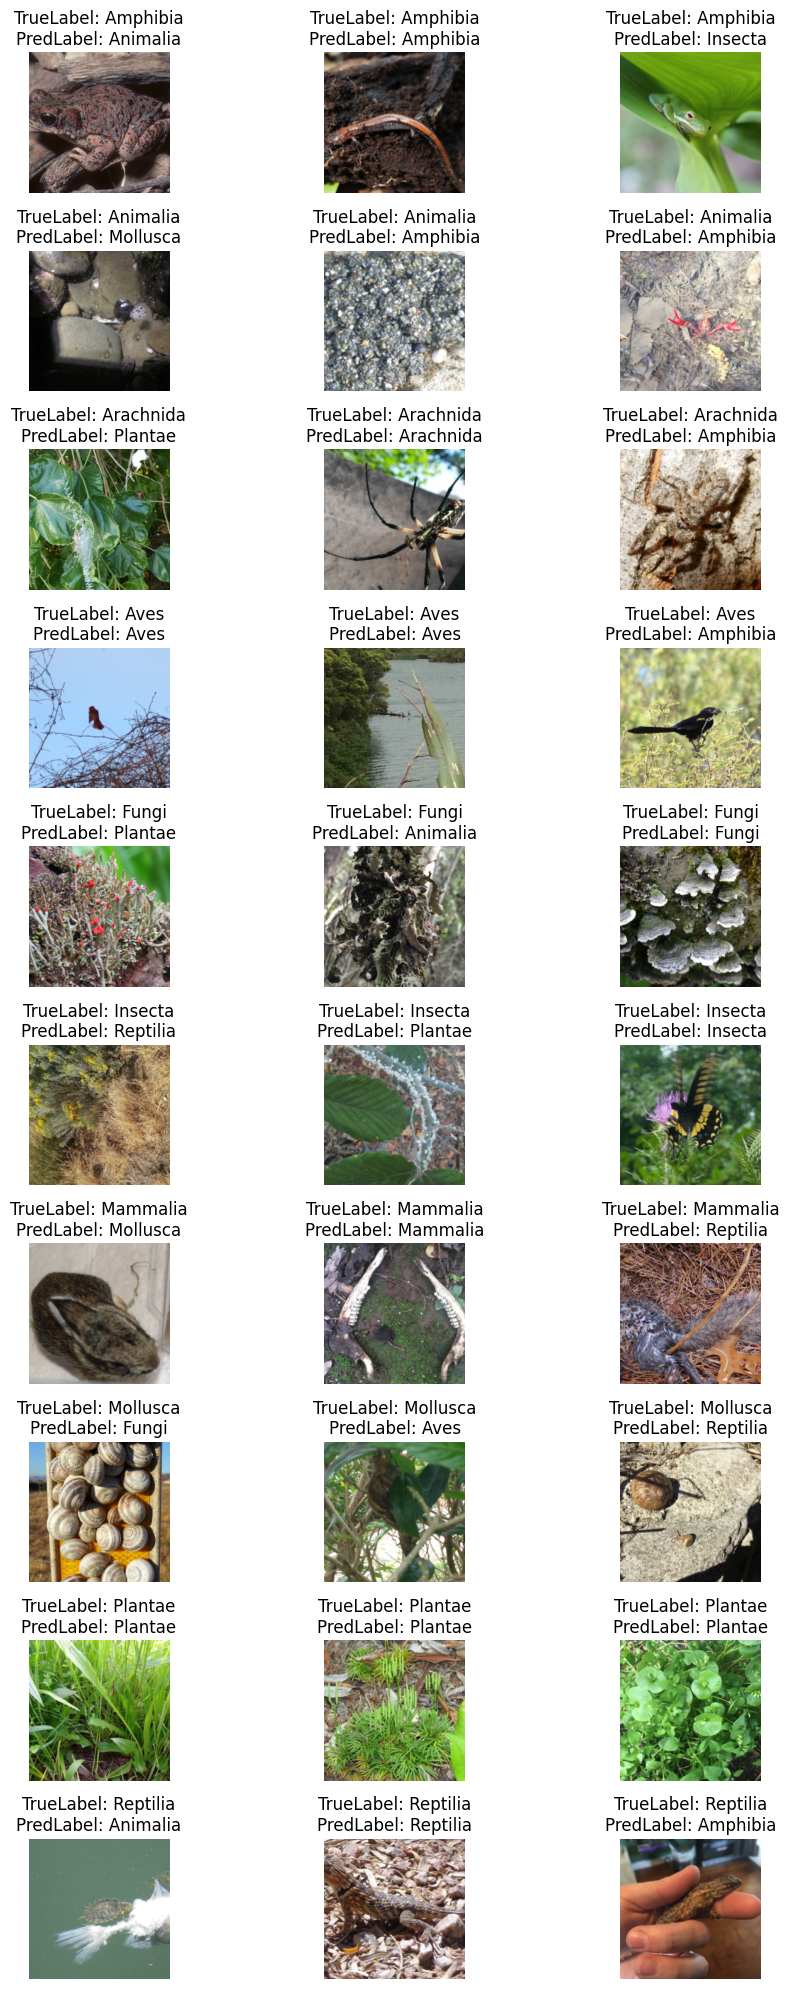

testing: loss=1.7208330326080323, top1_accuracy=39.3, top2_accuracy = 57.6


test_loss,▁
test_top1_accuracy,▁
test_top2_accuracy,▁
test_loss,1.72083
test_top1_accuracy,39.3
test_top2_accuracy,57.6


wandb: Agent Starting Run: 7pr8vveb with config:
wandb: 	activation: SiLU
wandb: 	base_dir: /kaggle/input/inaturalist/inaturalist_12K
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	filter_sizes: [3, 3, 3, 3, 3]
wandb: 	isBatchNormalization: False
wandb: 	isDataAug: False
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	n_neurons_denseLayer: 128
wandb: 	num_filters: [256, 128, 64, 64, 32]
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0001


Epoch 0:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 1:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 2:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 3:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running
Batch idx 160 running
Batch idx 200 running
Batch idx 240 running
Epoch 4:
Batch idx 0 running
Batch idx 40 running
Batch idx 80 running
Batch idx 120 running


wandb: Ctrl + C detected. Stopping sweep.


In [8]:
best_acc_sweep_configuration1 = {
    "method": "random",
    "name" : "visualize_sweep_final",
    "parameters": {
        "num_filters": {'values': [[256, 128, 64, 64, 32]]},
        "filter_sizes": {'values': [[3, 3, 3, 3, 3]]},
        "activation": {"values": ["SiLU"]},
        "optimizer": {"values": ["sgd"]},
        "learning_rate": {"values": [1e-3]},
        "weight_decay": {"values": [0.0001]},
        "momentum": {"values": [0.9]},
        "beta": {"values": [0.9]},
        "beta1": {"values":[0.9]},
        "beta2": {"values": [0.999]},
        "epsilon": {"values": [1e-8]},
        # "base_dir": {"values":["/content/drive/MyDrive/DL_Assignment2/Dataset/inaturalist_12K/"]},
        "base_dir": {"values": ["/kaggle/input/inaturalist/inaturalist_12K"]},
        "isDataAug": {"values": ["False"]},
        "isBatchNormalization": {"values": ["False"]},
        "dropout": {"values": [0.3]},
        "n_neurons_denseLayer": {"values": [128]},
        "batch_size": {"values": [32]},
        "epochs": {"values": [10]}
    }
}

def unnormalize(img):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img, 0, 1)

def visualizeOutputs(cnn, testDataLoader):
  cnn.eval()  # setting the model to evaluation model
  total_loss = 0.0
  n_correct = 0
  n_correct_top2 = 0
  n_samples = 0

  pred_output_perLabel = [[] for i in range(10)]
  x_values_perLabel = [[] for i in range(10)]
  
  with torch.no_grad():
    for batch_idx, (x_batch, y_batch) in enumerate(testDataLoader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      batch_outputs = cnn(x_batch)

      loss = nn.CrossEntropyLoss()(batch_outputs, y_batch)
      total_loss += loss.item() * x_batch.size(0)

      y_pred_batch = torch.argmax(batch_outputs, dim=1)
      n_correct += (y_pred_batch == y_batch).sum().item()
      n_samples += x_batch.size(0)

      y_pred_batch_top2 = torch.topk(batch_outputs, 2, dim=1).indices
      n_correct_top2 += y_pred_batch_top2.eq(y_batch.view(-1, 1)).sum().item()

      # Collecting 3 images per class
      for i in range(len(y_batch)):
        label = y_batch[i].item()
        if len(pred_output_perLabel[label]) < 3:
           x_values_perLabel[label].append(x_batch[i].cpu())
           pred_output_perLabel[label].append(y_pred_batch[i].item())

  labelNameList = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
  # Visualizing collected results
  fig, axes = plt.subplots(10, 3, figsize=(10, 20))
  plt.title("True Vs Pred results for each class label")
  for i in range(10):
     for j in range(3):
       predLabel = pred_output_perLabel[i][j]
       trueLabel = i 
       print(f"True = {trueLabel}, Pred = {predLabel}")
       image = x_values_perLabel[i][j]
       image = unnormalize(image)
       ax = axes[i, j]
       ax.imshow(image.permute(1, 2, 0)) 
       ax.set_title(f'TrueLabel: {labelNameList[trueLabel]}\nPredLabel: {labelNameList[predLabel]}')
       ax.axis('off')
  plt.tight_layout()
  wandb.log({"Grid": wandb.Image(plt)})
  plt.show()
  
  accuracy = (n_correct * 100.0) / n_samples
  avg_loss = total_loss / n_samples
  top2_accuracy = (n_correct_top2 * 100.0) / n_samples
  return accuracy, avg_loss, top2_accuracy

def visualization_sweep():
  wandb.init(mode="online")
  args = wandb.config
  train_loader, test_loader, val_loader, num_classes = load_data(args["base_dir"], args["isDataAug"], args["batch_size"])
  activationFun = args["activation"]
  optimizer = args["optimizer"]
  learning_rate = args["learning_rate"]
  momentum = args["momentum"]
  beta = args["beta"]
  beta1 = args["beta1"]
  beta2 = args["beta2"]
  epsilon = args["epsilon"]
  weight_decay = args["weight_decay"]
  dropout = args["dropout"]
  num_filters = args["num_filters"]
  filter_sizes = args["filter_sizes"]
  n_neurons_denseLayer = args["n_neurons_denseLayer"]
  isBatchNormalization = args["isBatchNormalization"]
  isDataAug = args["isDataAug"]

  wandb.run.name = f"{activationFun}_{optimizer}_{dropout}_{n_neurons_denseLayer}_DataAug-{isDataAug}_BatchNorm-{isBatchNormalization}"
  best_val_accuracy = 0.0
  best_accuracy_epoch = -1

  cnn = ConvolutionalNeuralNetwork(num_classes,
                                   num_filters, filter_sizes,
                                   activationFun, optimizer,
                                   n_neurons_denseLayer,
                                   isBatchNormalization, dropout,
                                   learning_rate,
                                   momentum, beta,
                                   beta1, beta2,
                                   epsilon, weight_decay)
  cnn.to(device)

  epochs = args["epochs"]
  for epochNum in range(epochs):
    print(f"Epoch {epochNum}:")
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
      if(batch_idx % 40 == 0):
        print(f"Batch idx {batch_idx} running")
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      cnn.optimizer.zero_grad()
      outputs = cnn(x_batch)
      cnn.backward(outputs, y_batch)
      cnn.updateWeights()
      del x_batch, y_batch, outputs

  test_accuracy, test_loss, test_top2_accuracy = visualizeOutputs(cnn, test_loader)
  print(f"testing: loss={test_loss}, top1_accuracy={test_accuracy}, top2_accuracy = {test_top2_accuracy}")

  wandb.log({
      "test_loss": test_loss,
      "test_top1_accuracy": test_accuracy,
      "test_top2_accuracy": test_top2_accuracy
  })

  
  del cnn,train_loader, test_loader, val_loader
  gc.collect()
  torch.cuda.empty_cache()

  wandb.finish()

wandb.login(key="73b92c51e182b0f526498c09acb70e0d4b8d6c14")
wandb_id = wandb.sweep(best_acc_sweep_configuration1, project="DA6401_Assignment2")
wandb.agent(wandb_id, function=visualization_sweep)